In [2]:
# libs 
import numpy as np 
import cv2 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 

/home/anirudh/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# get data from the BMPD_Db
dest_f = "BMPD_db"
for files in os.listdir(dest_f):
    sub_f = dest_f+"/"+files
    for file in os.listdir(sub_f):
        file_loc = sub_f+"/"+file
        img = cv2.imread(file_loc,0)
        #plt.imshow(img,cmap = 'gray')
    break

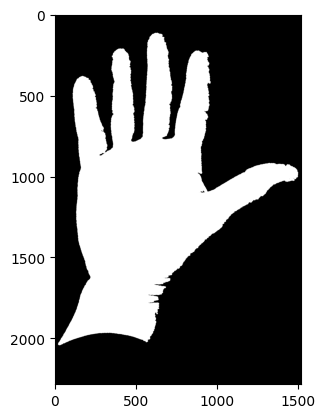

In [4]:
img1 = img.copy()

from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion, binary_dilation, disk
from skimage.segmentation import clear_border

# Threshold the image using Otsu's method
thresh = threshold_otsu(img1)
binary = img1 > thresh

# Remove the border and fill holes in the binary image
border = binary_erosion(binary, disk(3))
border = clear_border(border)
filled = binary_dilation(border, disk(5))

# Invert the binary image to get the mask
mask = np.logical_not(filled)

# Display the mask
plt.imshow(filled, cmap='gray')
plt.show()

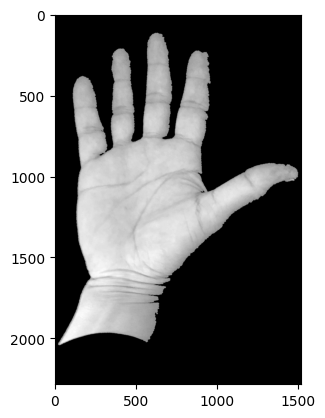

In [5]:
masked_img = cv2.bitwise_and(img, img, mask= np.uint8(filled)*255)
plt.imshow(masked_img,cmap = 'gray')

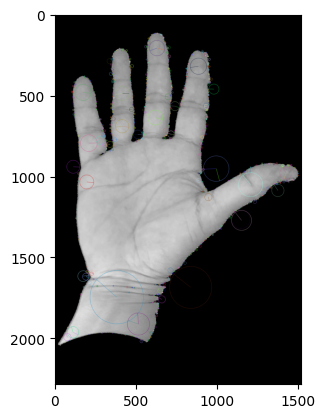

In [9]:
# Create SIFT object
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
kp, des = sift.detectAndCompute(masked_img, None)

# Draw keypoints on the original image
img_with_kp = cv2.drawKeypoints(masked_img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


plt.imshow(img_with_kp,cmap = 'gray')


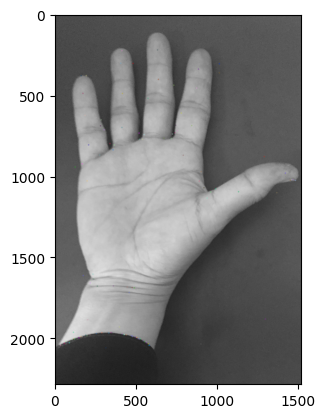

In [44]:
sift = cv2.SIFT_create()
# find the keypoints on image (grayscale)
kp = sift.detect(img,None)

# draw keypoints in image
img2 = cv2.drawKeypoints(img, kp, None, flags=0)

plt.imshow(img2,cmap = 'gray')